### Imports 

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym import spaces

import seaborn as sns

###  Environment

The environment is a simpler version of the popular blackjack game. The environment is taken from the Sutton & Barto book Example 5.1.  
Objective of the game is to obtain cards, the sum of whose numerical value is as great as possible without exceeding 21. All the face cards are counted as 10, and an ace can be counted either as 1 or 11.
In this version of the game, the player and dealer only compete with each other. In the actual version of the game there are multiple players playing against the dealer.
To begin, both the player and the dealer are dealt with(given) 2 cards. If the player's cards has the sum of 21, the player wins immediately unless the dealer also has a sum of 21, if that is the case then the game is drawn. One of the dealer's card is face up and one is face down, i.e. player can see one card of the dealer.
If the player does not have a 21 to begin with(which usually is the case), then he can request for another card, one by one(called hits), until he stops(sticks) or his sum exceeds 21(meaning he goes bust and loses). If the player sticks then it becomes the dealer's turn. The dealer follows a fixed strategy, he "hits" for any sum less than 17 and "sticks" otherwise. If the dealer goes bust(i.e his sum exceeds 21) then player wins.
There are three final outcomes; win, draw, lose. The final outcome is determined by whose final sum is closer to 21.

Each game of blackjack is considered as an episode. Rewards for winning, drawing and losing are +1, 0, -1 respectively. There are no immediate rewards, the terminal rewards are the returns. The state of the player depends on the player's cards and the dealers visible card. We assume that the cards are dealt from an infinite deck with replacement. If the player holds an ace that he could count as 11 without going bust, then the ace is said to be usable. In this case it is always counted as 11. Thus, the player makes decision based on three variables, his current sum, the dealers showing card and whether or not he holds an usable ace.

His current sum can go from (4 - 32). As the minimum will be when he has both 2's, since if he has either of the card as one, then it will be counted as 11 and it will make the sum larger.

The dealers card can be from (1-10).

Usable ace can be either True or False.

Total States  = 29 * 10 * 2 = 580
Total Actions = 2



#### MDP

**States**

- Current Sum
- Dealers Showing Card
- Usable Ace

**Actions**

Stick or Hit

**Rewards**

+1, 0, -1



### Deterministic Environment - BlackJack

In [3]:
class BlackJackEnv(gym.Env):
    
    metadata = {'render.modes':['human']}
    
    def __init__(self):
        self.observation_space = spaces.Discrete(580)       
        self.action_space = spaces.Discrete(2)
        self.step_count = 0                        ### Number of actions taken in the game till now
    
    
    def check_usable_ace(self,hand):
        
        '''
        input  - player or dealer's hand
        output - True or False, depending on if the hand has usable ace or not
        
        function to check if any hand has an usable ace.
        if yes, then replaces that 1 with 11 in the hand as the 1 is counted as 11 in this case.
        
        '''
            ### Creating a temporary hand taking the Ace's value as 11 to check of usability
        temp_hand = hand.copy()
        
        ### Checking if the hand has any ace, if not then returns False
        if np.any(temp_hand == 1):
            
            ### If the hand has any ace then replace the ace(1) with 11 in the temporary hand, 
            ### if there are more than one ace then replaces the first ace(1) with 11
            
            temp_hand[np.where(temp_hand == 1)[0][0]] = 11

            ### After replacement if sum is less than equal to 21, then the ace is usable
            if temp_hand.sum() <= 21:
                return True

        return False
        
    def use_ace(self,hand):
        '''
        input - player or dealer's hand
        output - new hand with ace(1) replaced with 11
        '''
        temp_hand = hand.copy()
        temp_hand[np.where(temp_hand == 1)[0][0]] = 11
        return temp_hand
        
    
    def reset(self):
        
        '''
        function to reset the environment's state
        '''
        
        ### New Player Hand
        self.current_hand = np.random.choice(range(1,11),2)
        
        ### Initialising Usable Ace as False
        
        self.usable_ace = False
        
        ### Variable is used to inform whether the dealer has sticked,
        ### Used to know when to terminate the game
        
        self.dealer_stick = False
        self.player_stick = False
    
        
        ### Checking if player hand has Usable Ace, if yes, then replacing it with 11.  
        if self.check_usable_ace(self.current_hand):
            self.usable_ace = True
            self.current_hand = self.use_ace(self.current_hand)
            
        ### State variable Current Sum        
        self.current_sum = self.current_hand.sum()
        
        ### Dealer's New Hand
        self.dealer_hand = np.random.choice(range(1,11),2)
        
        ### Dealer's Sum
        self.dealer_sum = self.dealer_hand.sum()
        
        ### State Variable: Dealer Showing Card
        self.dealer_showing_card = self.dealer_hand[0]
        
        ### Checking if Dealer's hand has Usable Ace, if yes, then replacing it with 11.  
        if self.check_usable_ace(self.dealer_hand):
            temp_dealer_hand = self.use_ace(self.dealer_hand)
            self.dealer_sum = temp_dealer_hand.sum()
            
        
    def take_turn(self,player):
        
        '''
        Used to play one turn of the player, Called from "step()" funtion, depending upon the game state
        player can have two values - 'player' or 'dealer'
        
        For each type of player it does the same thing, just changing different variables
        
        It takes a new random card, adds to the players hand. If there is usable ace, 
        then replaces ace(1) with 11.
        
        '''
        
        if player == 'dealer':
            
            ### takes a new random card
            new_card = np.random.choice(range(1,11))
            
            ### adding new card to the players hand and making a temporary new hand
            new_dealer_hand = np.array(self.dealer_hand.tolist() +  [new_card])
            
            ### Check if there is usable ace
            if self.check_usable_ace(new_dealer_hand):
                
                ### replace ace(1) with 11
                new_dealer_hand = self.use_ace(new_dealer_hand)
            
            ### Assigning the temporary hand to the players actual hand
            self.dealer_hand = new_dealer_hand
            
            ### Updating the players hand sum variable
            self.dealer_sum = self.dealer_hand.sum()
                
        if player == 'player':
            
            ### takes a new random card
            new_card = np.random.choice(range(1,11))
           
            ### adding new card to the players hand and making a temporary new hand
            new_player_hand = np.array(self.current_hand.tolist()+ [new_card])
            
            ### Check if there is usable ace
            if self.check_usable_ace(new_player_hand):
                
                ### replace ace(1) with 11
                self.usable_ace = True
                new_player_hand = self.use_ace(new_player_hand)
            
            ### Assigning the temporary hand to the players actual hand
            self.current_hand = new_player_hand
            ### Updating the players hand sum variable
            self.current_sum = self.current_hand.sum()
            
        
    def check_game_status(self, mode = 'normal'):
        
        '''
         checks the status of the game, there are two modes
         'normal' mode - the default mode, this is used to check after 
                         each turn whether a terminal state has been reached
         'compare' mode - used when we need to compare the totals of both the players
                          to judge the winner
             
         
         returns a result dictionary with the winner, whether the game is finished 
         and the reward of the game
        '''
        result = {'winner':'',
                 'is_done': False,
                 'reward':0}
        
        
        if mode == 'normal':
        
            if self.current_sum > 21:
                result['winner'] = 'dealer'
                result['is_done'] = True
                result['reward'] = -1
            elif self.dealer_sum > 21:
                result['winner'] = 'player'
                result['is_done'] = True
                result['reward'] = 1

            elif self.current_sum == 21:
                result['winner'] = 'player'
                result['is_done'] = True
                result['reward'] = 1

            elif self.dealer_sum == 21:
                result['winner'] = 'dealer'
                result['is_done'] = True
                result['reward'] = -1
        
        elif mode == 'compare':
            
            result['is_done'] = True
            diff_21_player = 21 - self.current_sum 
            diff_21_dealer = 21 - self.dealer_sum

            if diff_21_player > diff_21_dealer:
                result['reward'] = -1
                result['winner'] = 'dealer'
            elif diff_21_player < diff_21_dealer:
                result['reward'] = 1
                result['winner'] = 'player'
            else:
                result['reward'] = 0
                result['winner'] = 'draw'
            
            return result
        
        
        return result
    
    def step(self,action):
        
        '''
        Performs one action, either Hit or Stick
        
        returns - a result dictionary with the winner, whether the game is finished 
        and the reward of the game
        
        '''
        
        self.step_count += 1  ### Number of actions taken in the game till now
        
        
        result = {'winner':'',
                 'is_done': False,
                 'reward':0} 
        
        ### Before taking the first step of the game we need to check for "natural" 
        ### winning condition if the initial two cards of the players are 21
        ### If anyone has 21, then that player wins, if both have 21, then the game is 
        ### drawn. Otherwise the game will continue
        
        if self.step_count == 1:
            if self.check_usable_ace(self.current_hand):
                self.current_hand = self.use_ace(self.current_hand)
            if self.check_usable_ace(self.dealer_hand):
                self.current_hand = self.use_ace(self.dealer_hand)
            
            if self.current_sum == 21 and self.dealer_sum == 21:
                result['is_done'] = True
                result['reward'] = 0
                result['winner'] = 'draw'
                return result
                
            elif self.current_sum == 21 and self.dealer_sum < 21:
                result['is_done'] = True
                result['reward'] = 1
                result['winner'] = 'player'
                return result
                
            elif self.dealer_sum == 21 and self.current_sum < 21:
                result['is_done'] = True
                result['reward'] = -1
                result['winner'] = 'dealer'
                return result
            
            if self.dealer_sum >= 17:
                self.dealer_stick = True
        
        ### action = 0, meaning "hit"
        
        if action == 0: 
            
            ### Player Takes Turn
            self.take_turn('player')
            
            ### Checking game status 
            result = self.check_game_status()
            if result['is_done'] == True:
                return result
                
                
        
        if action == 1:  ### stick
            
            if self.dealer_stick == True:  ### if dealer has already sticked
                  return self.check_game_status(mode = 'compare')
            
            ### if dealer has not sticked, the dealer hits unless his sum >= 17, then he sticks
            
            ### Dealers Turn
            while self.dealer_sum < 17:
                
                self.take_turn('dealer')
                result = self.check_game_status()
                #game_status = result['is_done']    ### To check game status after Dealer sticks
                if result['is_done'] == True:
                    return result
            
            ### if the game is not finished yet, then we set dealer_stick status to True
            ### This means that our player can hit or stick 
            
            
            self.dealer_stick = True
            
          
        return result
        
        
    def get_current_state(self):
        '''
        returns the current state variables, current_sum, dealer_showing_card, usable_ace
        '''
        current_state = {}
        
        current_state['current_sum'] = self.current_sum
        current_state['dealer_showing_card'] = self.dealer_showing_card
        current_state['usable_ace'] = self.usable_ace
        
        return current_state
    
    
    def render(self):
        
        print('OBSERVABLE STATES')
        print('Current Sum - {}'.format(self.current_sum))
        print('Dealer Showing Card - {}'.format(self.dealer_showing_card))
        print('Usable Ace - {}'.format(self.usable_ace))
        
        print('AUXILLARY INFORMATION ------------------------------')
        print('Current Hand - {}'.format(self.current_hand))
        print('Dealer Hand - {}'.format(self.dealer_hand))
        print('Dealer Sum - {}'.format(self.dealer_sum))
    
    

##### Usage Example (One Episode)

In [4]:
bj = BlackJackEnv()

In [12]:
bj.reset()
bj.render()

OBSERVABLE STATES
Current Sum - 12
Dealer Showing Card - 3
Usable Ace - False
AUXILLARY INFORMATION ------------------------------
Current Hand - [7 5]
Dealer Hand - [3 2]
Dealer Sum - 5


In [13]:
print(bj.step(0))  ### Action = Hit
bj.render()

{'winner': '', 'is_done': False, 'reward': 0}
OBSERVABLE STATES
Current Sum - 18
Dealer Showing Card - 3
Usable Ace - False
AUXILLARY INFORMATION ------------------------------
Current Hand - [7 5 6]
Dealer Hand - [3 2]
Dealer Sum - 5


In [14]:
print(bj.step(1)) ### Action = Stick,  Once the player "Sticks", the dealer hits unitil its sum < 17, after that it stops
bj.render()

{'winner': '', 'is_done': False, 'reward': 0}
OBSERVABLE STATES
Current Sum - 18
Dealer Showing Card - 3
Usable Ace - False
AUXILLARY INFORMATION ------------------------------
Current Hand - [7 5 6]
Dealer Hand - [3 2 8 6]
Dealer Sum - 19


In [15]:
print(bj.step(1)) ### Action = Stick
bj.render()

{'winner': 'dealer', 'is_done': True, 'reward': -1}
OBSERVABLE STATES
Current Sum - 18
Dealer Showing Card - 3
Usable Ace - False
AUXILLARY INFORMATION ------------------------------
Current Hand - [7 5 6]
Dealer Hand - [3 2 8 6]
Dealer Sum - 19


### Stochastic Environment -  BlackJack

In [16]:
class BlackJackEnv_Stochastic(gym.Env):
    
    metadata = {'render.modes':['human']}
    
    def __init__(self):
        self.observation_space = spaces.Discrete(580)       
        self.action_space = spaces.Discrete(2)
        self.step_count = 0                        ### Number of actions taken in the game till now
    
    
    def check_usable_ace(self,hand):
        
        '''
        input  - player or dealer's hand
        output - True or False, depending on if the hand has usable ace or not
        
        function to check if any hand has an usable ace.
        if yes, then replaces that 1 with 11 in the hand as the 1 is counted as 11 in this case.
        
        '''
            ### Creating a temporary hand taking the Ace's value as 11 to check of usability
        temp_hand = hand.copy()
        
        ### Checking if the hand has any ace, if not then returns False
        if np.any(temp_hand == 1):
            
            ### If the hand has any ace then replace the ace(1) with 11 in the temporary hand, 
            ### if there are more than one ace then replaces the first ace(1) with 11
            
            temp_hand[np.where(temp_hand == 1)[0][0]] = 11

            ### After replacement if sum is less than equal to 21, then the ace is usable
            if temp_hand.sum() <= 21:
                return True

        return False
        
    def use_ace(self,hand):
        '''
        input - player or dealer's hand
        output - new hand with ace(1) replaced with 11
        '''
        temp_hand = hand.copy()
        temp_hand[np.where(temp_hand == 1)[0][0]] = 11
        return temp_hand
        
    
    def reset(self):
        
        '''
        function to reset the environment's state
        '''
        
        ### New Player Hand
        self.current_hand = np.random.choice(range(1,11),2)
        
        ### Initialising Usable Ace as False
        
        self.usable_ace = False
        
        ### Variable is used to inform whether the dealer has sticked,
        ### Used to know when to terminate the game
        
        self.dealer_stick = False
        self.player_stick = False
    
        
        ### Checking if player hand has Usable Ace, if yes, then replacing it with 11.  
        if self.check_usable_ace(self.current_hand):
            self.usable_ace = True
            self.current_hand = self.use_ace(self.current_hand)
            
        ### State variable Current Sum        
        self.current_sum = self.current_hand.sum()
        
        ### Dealer's New Hand
        self.dealer_hand = np.random.choice(range(1,11),2)
        
        ### Dealer's Sum
        self.dealer_sum = self.dealer_hand.sum()
        
        ### State Variable: Dealer Showing Card
        self.dealer_showing_card = self.dealer_hand[0]
        
        ### Checking if Dealer's hand has Usable Ace, if yes, then replacing it with 11.  
        if self.check_usable_ace(self.dealer_hand):
            temp_dealer_hand = self.use_ace(self.dealer_hand)
            self.dealer_sum = temp_dealer_hand.sum()
            
        
    def take_turn(self,player):
        
        '''
        Used to play one turn of the player, Called from "step()" funtion, depending upon the game state
        player can have two values - 'player' or 'dealer'
        
        For each type of player it does the same thing, just changing different variables
        
        It takes a new random card, adds to the players hand. If there is usable ace, 
        then replaces ace(1) with 11.
        
        '''
        
        if player == 'dealer':
            
            ### takes a new random card
            new_card = np.random.choice(range(1,11))
            
            ### adding new card to the players hand and making a temporary new hand
            new_dealer_hand = np.array(self.dealer_hand.tolist() +  [new_card])
            
            ### Check if there is usable ace
            if self.check_usable_ace(new_dealer_hand):
                
                ### replace ace(1) with 11
                new_dealer_hand = self.use_ace(new_dealer_hand)
            
            ### Assigning the temporary hand to the players actual hand
            self.dealer_hand = new_dealer_hand
            
            ### Updating the players hand sum variable
            self.dealer_sum = self.dealer_hand.sum()
                
        if player == 'player':
            
            ### takes a new random card
            new_card = np.random.choice(range(1,11))
           
            ### adding new card to the players hand and making a temporary new hand
            new_player_hand = np.array(self.current_hand.tolist()+ [new_card])
            
            ### Check if there is usable ace
            if self.check_usable_ace(new_player_hand):
                
                ### replace ace(1) with 11
                self.usable_ace = True
                new_player_hand = self.use_ace(new_player_hand)
            
            ### Assigning the temporary hand to the players actual hand
            self.current_hand = new_player_hand
            ### Updating the players hand sum variable
            self.current_sum = self.current_hand.sum()
            
        
    def check_game_status(self, mode = 'normal'):
        
        '''
         checks the status of the game, there are two modes
         'normal' mode - the default mode, this is used to check after 
                         each turn whether a terminal state has been reached
         'compare' mode - used when we need to compare the totals of both the players
                          to judge the winner
             
         
         returns a result dictionary with the winner, whether the game is finished 
         and the reward of the game
        '''
        result = {'winner':'',
                 'is_done': False,
                 'reward':0}
        
        
        if mode == 'normal':
        
            if self.current_sum > 21:
                result['winner'] = 'dealer'
                result['is_done'] = True
                result['reward'] = -1
            elif self.dealer_sum > 21:
                result['winner'] = 'player'
                result['is_done'] = True
                result['reward'] = 1

            elif self.current_sum == 21:
                result['winner'] = 'player'
                result['is_done'] = True
                result['reward'] = 1

            elif self.dealer_sum == 21:
                result['winner'] = 'dealer'
                result['is_done'] = True
                result['reward'] = -1
        
        elif mode == 'compare':
            
            result['is_done'] = True
            diff_21_player = 21 - self.current_sum 
            diff_21_dealer = 21 - self.dealer_sum

            if diff_21_player > diff_21_dealer:
                result['reward'] = -1
                result['winner'] = 'dealer'
            elif diff_21_player < diff_21_dealer:
                result['reward'] = 1
                result['winner'] = 'player'
            else:
                result['reward'] = 0
                result['winner'] = 'draw'
            
            return result
        
        
        return result
    
    def step(self,action_intended):
        
        '''
        Performs one action, either Hit or Stick
        
        returns - a result dictionary with the winner, whether the game is finished 
        and the reward of the game
        
        '''
        
        self.step_count += 1  ### Number of actions taken in the game till now
        
        
        result = {'winner':'',
                 'is_done': False,
                 'reward':0} 
        
        ### Before taking the first step of the game we need to check for "natural" 
        ### winning condition if the initial two cards of the players are 21
        ### If anyone has 21, then that player wins, if both have 21, then the game is 
        ### drawn. Otherwise the game will continue
        
        if self.step_count == 1:
            if self.check_usable_ace(self.current_hand):
                self.current_hand = self.use_ace(self.current_hand)
            if self.check_usable_ace(self.dealer_hand):
                self.current_hand = self.use_ace(self.dealer_hand)
            
            if self.current_sum == 21 and self.dealer_sum == 21:
                result['is_done'] = True
                result['reward'] = 0
                result['winner'] = 'draw'
                return result
                
            elif self.current_sum == 21 and self.dealer_sum < 21:
                result['is_done'] = True
                result['reward'] = 1
                result['winner'] = 'player'
                return result
                
            elif self.dealer_sum == 21 and self.current_sum < 21:
                result['is_done'] = True
                result['reward'] = -1
                result['winner'] = 'dealer'
                return result
            
            if self.dealer_sum >= 17:
                self.dealer_stick = True
        
        
        #### Adding Stochastic Behaviour
        
        p = []
        if action_intended == 0:
            p = [0.90, 0.10]
        else:
             p = [0.10, 0.90]
            
        #### If intended action is 0(hit), then choosing that action with 90% probability
        #### If intended action is 1(stick), then choosing that action with 90% probability
        
        action = np.random.choice([0,1], p = p)
        
        
        
        ### action = 0, meaning "hit"
        
        if action == 0: 
            
            ### Player Takes Turn
            self.take_turn('player')
            
            ### Checking game status 
            result = self.check_game_status()
            if result['is_done'] == True:
                return result
                
                
        
        if action == 1:  ### stick
            
            if self.dealer_stick == True:  ### if dealer has already sticked
                  return self.check_game_status(mode = 'compare')
            
            ### if dealer has not sticked, the dealer hits unless his sum >= 17, then he sticks
            
            ### Dealers Turn
            while self.dealer_sum < 17:
                
                self.take_turn('dealer')
                result = self.check_game_status()
                #game_status = result['is_done']    ### To check game status after Dealer sticks
                if result['is_done'] == True:
                    return result
            
            ### if the game is not finished yet, then we set dealer_stick status to True
            ### This means that our player can hit or stick 
            
            
            self.dealer_stick = True
            
          
        return result
        
        
    def get_current_state(self):
        '''
        returns the current state variables, current_sum, dealer_showing_card, usable_ace
        '''
        current_state = {}
        
        current_state['current_sum'] = self.current_sum
        current_state['dealer_showing_card'] = self.dealer_showing_card
        current_state['usable_ace'] = self.usable_ace
        
        return current_state
    
    
    def render(self):
        
        print('OBSERVABLE STATES')
        print('Current Sum - {}'.format(self.current_sum))
        print('Dealer Showing Card - {}'.format(self.dealer_showing_card))
        print('Usable Ace - {}'.format(self.usable_ace))
        
        print('AUXILLARY INFORMATION ------------------------------')
        print('Current Hand - {}'.format(self.current_hand))
        print('Dealer Hand - {}'.format(self.dealer_hand))
        print('Dealer Sum - {}'.format(self.dealer_sum))
    
    

##### Usage Example 

In [26]:
bjs = BlackJackEnv_Stochastic()

In [49]:
bjs.reset()
bjs.render()


OBSERVABLE STATES
Current Sum - 10
Dealer Showing Card - 2
Usable Ace - False
AUXILLARY INFORMATION ------------------------------
Current Hand - [2 8]
Dealer Hand - [2 4]
Dealer Sum - 6


In [50]:
bjs.step(1) ### The action intended was 1(stick), but the change in states show that the action taken was 0(hit)
bjs.render()

OBSERVABLE STATES
Current Sum - 19
Dealer Showing Card - 2
Usable Ace - False
AUXILLARY INFORMATION ------------------------------
Current Hand - [2 8 9]
Dealer Hand - [2 4]
Dealer Sum - 6


In [51]:
bjs.step(1) ### The action intended was 1(stick), and the player states show us that the action was infact 1(stick), 
            ### as there is no change in the player sum
bjs.render()

OBSERVABLE STATES
Current Sum - 19
Dealer Showing Card - 2
Usable Ace - False
AUXILLARY INFORMATION ------------------------------
Current Hand - [2 8 9]
Dealer Hand - [2 4 7 6]
Dealer Sum - 19


### Tabular Method

#### Q-Learning Explained

Q-Learning is a model free, off policy tabular method to learn the action-state value function for a MDP. Since this is a model free method we do not require a specific state-transition probability matrix. Q Learning uses bootstrapping, we take one step in the environment, observe the reward and next state, then update the state-action function value for the current state and the action taken Q(S,A) using the Q values for the next_state and the next_action. 
While updating the Q(S,A) for the current state and action, for calculating the state-action value for the next state, we take the action which has the maximum Q value for the next state. Hence this makes Q-Learning off policy, as while updating the estimate of the current Q(S,A), the next action that we take does not come from the current policy(derived from Q) but we choose action with the max Q value for the next state.


#### Q- Learning Util Functions 

**Q Table Information **

- first dimension  - current sum(4-32)                                   
- second dimension - dealers showing card (1-10)
- third dimension  - usable ace (False,True) 
- fourth dimension - action (stick, hit)

In [52]:

#### following are 4 dictionaries which help in converting the 
#### state values like current_sum and action to indexes in the Q value table


current_sum_to_index = dict(zip(np.arange(4,33),np.arange(29)))  
dealer_showing_card_to_index = dict(zip(np.arange(1,11),np.arange(10)))
usable_ace_index = dict(zip([False,True],[0,1]))
action_index = dict(zip(['hit','stick'],[0,1]))

def get_state_q_indices(current_state):
    
    '''
    used to get indices of the Q table for any given state 
    
    '''
    current_sum_idx = current_sum_to_index[current_state['current_sum']]
    dealer_showing_card_idx = dealer_showing_card_to_index[current_state['dealer_showing_card']]
    usable_ace_idx = usable_ace_index[current_state['usable_ace']]
    
    return [current_sum_idx,dealer_showing_card_idx,usable_ace_idx]

def get_max_action(Q_sa, current_state):
    
    '''
    used to get the action with the max q-value given the current state and the Q table
    
    '''

    state_q_idxs = get_state_q_indices(current_state)
    action = Q_sa[state_q_idxs[0],state_q_idxs[1],state_q_idxs[2],:].argmax() ## stick = 0, hit = 1
    ### if q value of both equal returns stick
    
    ### can make it epsilon greedy
    
    return action

def get_q_value(Q_sa, state, action):
    '''
    used to get Q value for any given state and action, given the Q table
    
    '''
    state_q_idxs = get_state_q_indices(state)
    q_value = Q_sa[state_q_idxs[0],state_q_idxs[1],state_q_idxs[2],action]

    return q_value

#### Q-Learning  

In [53]:
### first dimension  - current sum (4-32)
### second dimension - dealers showing card (1-10)
### third dimension  - usable ace (False,True) 
### fourth dimension - action (hit, stick)

Q = np.zeros((29,10,2,2)) #### Initializing the Q value Table with zeros

In [54]:
episode_count = 0
total_episodes = 1000000
gamma = 0.9             #### the discount factor
alpha = 0.1             #### learning rate
bj = BlackJackEnv()


while episode_count < total_episodes:
    
    
    bj.reset()  ### Initialize S (the environment's starting state)
    

    current_state = bj.get_current_state()
    current_action = get_max_action(Q, current_state)
    
    
    ### Take Action
    step_result = bj.step(current_action)
    
    next_state = bj.get_current_state()
    next_max_action = get_max_action(Q, next_state)
    immediate_reward = step_result['reward']
    
    
    
    next_state_q_idxs = get_state_q_indices(next_state)
    
    #### Get Q value for the next state and max action in the next state
    q_max_s_a = get_q_value(Q, next_state, next_max_action)
    
    td_target = immediate_reward + gamma * q_max_s_a
    
    #### Getting Q value for the current state and action
    q_current_s_a = get_q_value(Q, current_state, current_action)
    
    td_error = td_target - q_current_s_a
    
    state_q_idxs = get_state_q_indices(current_state)
    
    #### Updating current Q(S,A)
    Q[state_q_idxs[0],state_q_idxs[1],state_q_idxs[2],current_action] = q_current_s_a + alpha*td_error
                                                                        
    current_state = next_state  ### S=S'
    
    if step_result['is_done']:
        episode_count+=1
        
        if episode_count%100000 == 0:
            print('---------Episode - {} -----------'.format(episode_count))
            
   

---------Episode - 100000 -----------
---------Episode - 200000 -----------
---------Episode - 300000 -----------
---------Episode - 400000 -----------
---------Episode - 500000 -----------
---------Episode - 600000 -----------
---------Episode - 700000 -----------
---------Episode - 800000 -----------
---------Episode - 900000 -----------
---------Episode - 1000000 -----------


### Q Value Plots 

#### Usable Ace = False

Text(609.9818181818181, 0.5, 'Current Player Sum')

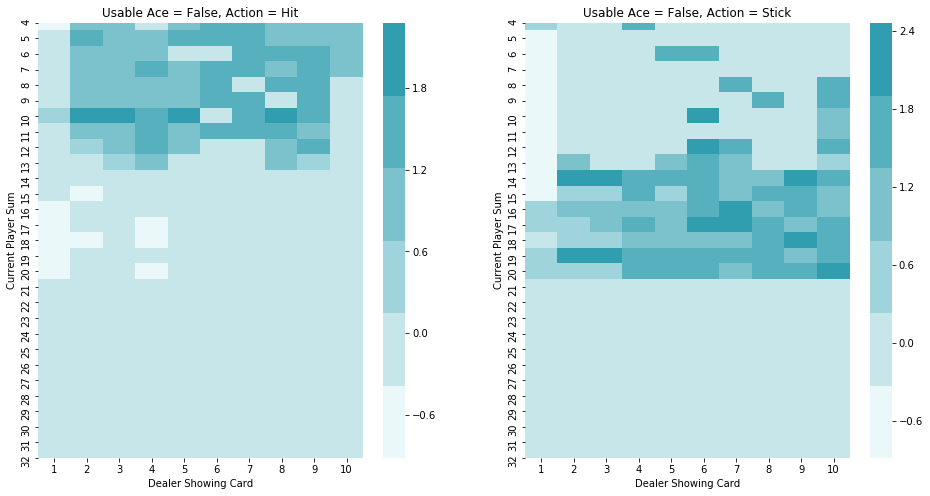

In [55]:
fig, ax = plt.subplots(ncols= 2,figsize=(16,8)) 
sns.heatmap(Q[:,:,0,0],cmap = sns.light_palette((210, 90, 60), input="husl"), ax = ax[0], 
            xticklabels=np.arange(1,11),yticklabels=np.arange(4,33))
ax[0].set_title('Usable Ace = False, Action = Hit')
ax[0].set_xlabel('Dealer Showing Card')
ax[0].set_ylabel('Current Player Sum')


sns.heatmap(Q[:,:,0,1],cmap = sns.light_palette((210, 90, 60), input="husl"), ax = ax[1],
           xticklabels=np.arange(1,11),yticklabels=np.arange(4,33))
ax[1].set_title('Usable Ace = False, Action = Stick')
ax[1].set_xlabel('Dealer Showing Card')
ax[1].set_ylabel('Current Player Sum')

> Using the table we can easily see which action is good to take in each state. It has learned that when the current sum is less than 12-13 it is good to Hit. Also we can see that for higher dealer showing card and greater values of current_sum it is better to stick

#### Usable Ace = True

Text(609.9818181818181, 0.5, 'Current Player Sum')

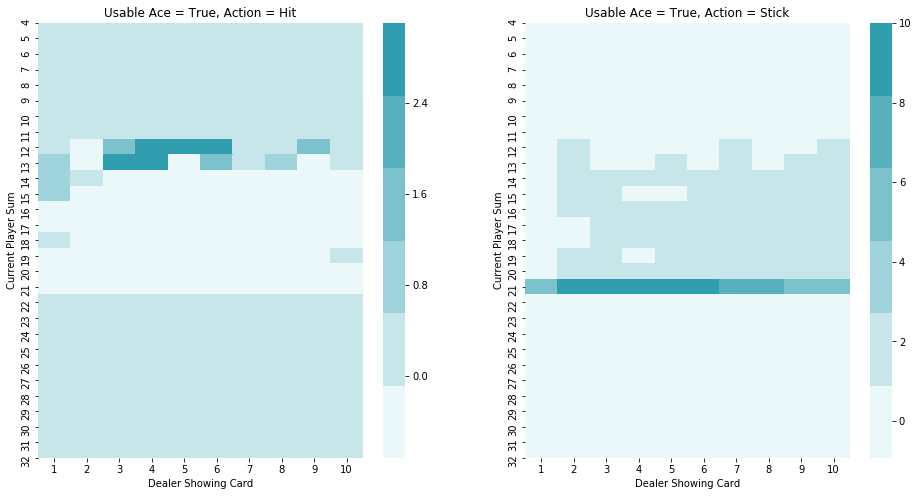

In [56]:
fig, ax = plt.subplots(ncols = 2, figsize=(16,8)) 
sns.heatmap(Q[:,:,1,0],cmap = sns.light_palette((210, 90, 60), input="husl"), ax = ax[0],
           xticklabels=np.arange(1,11),yticklabels=np.arange(4,33))
ax[0].set_title('Usable Ace = True, Action = Hit')
ax[0].set_xlabel('Dealer Showing Card')
ax[0].set_ylabel('Current Player Sum')


sns.heatmap(Q[:,:,1,1],cmap = sns.light_palette((210, 90, 60), input="husl"), ax =  ax[1],
           xticklabels=np.arange(1,11),yticklabels=np.arange(4,33))
ax[1].set_title('Usable Ace = True, Action = Stick')
ax[1].set_xlabel('Dealer Showing Card')
ax[1].set_ylabel('Current Player Sum')

>Since the samples for Usable Ace = True are very sparse, the Q Values patterns are not very clear, but we still can see the general pattern that if the current sum > 13 it is good to "Stick" when the dealer showing card is towards the higher end.
Also, for current sum around 11-12 it is good to "Hit" if Usable Ace = True

### Learned Policy 

Following are learned policy plots using the Q Table (Greedy Policy) for all non terminal states

#### Usable Ace = False 

Text(51.0, 0.5, 'Current Player Sum')

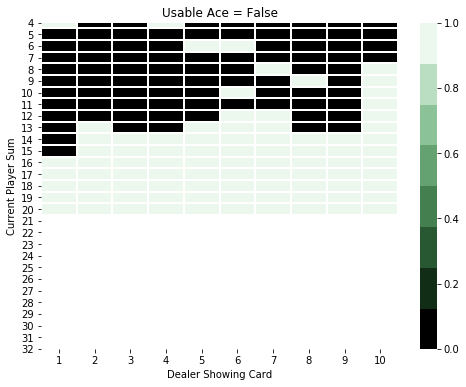

In [57]:
fig, ax = plt.subplots(ncols= 1,figsize=(8,6)) 
sns.heatmap(np.argmax(Q[:17,:,0,:],axis=2),cmap = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, reverse=True)\
           ,linewidths=1,xticklabels=np.arange(1,11),yticklabels=np.arange(4,33))
ax.set_title('Usable Ace = False')
ax.set_xlabel('Dealer Showing Card')
ax.set_ylabel('Current Player Sum')

> Black Blocks Indicate to Take Action "Hit" , As Hit corresponds to action = 0

#### Usable Ace = True 

Text(51.0, 0.5, 'Current Player Sum')

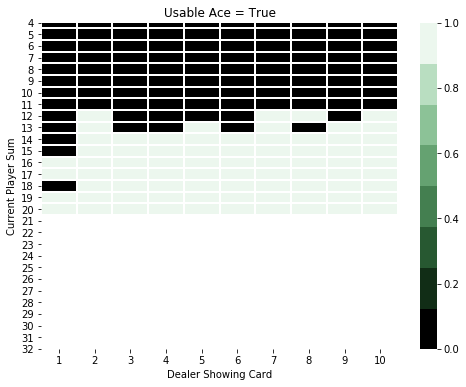

In [58]:
fig, ax = plt.subplots(ncols= 1,figsize=(8,6)) 
sns.heatmap(np.argmax(Q[:17,:,1,:],axis=2),cmap = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, reverse=True)\
           ,linewidths=1,xticklabels=np.arange(1,11),yticklabels=np.arange(4,33))
ax.set_title('Usable Ace = True')
ax.set_xlabel('Dealer Showing Card')
ax.set_ylabel('Current Player Sum')

> Black Blocks Indicate to Take Action "Hit" , As Hit corresponds to action = 0